### Objective: To apply SVM on amazon fine food reviews 

In [1]:
import warnings
warnings.filterwarnings("ignore")

#import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re

import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_validate


In [3]:
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression


In [4]:
#from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import TimeSeriesSplit,GridSearchCV
#from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC

In [6]:
# Loading data 
customer_reviews = pd.read_csv('Reviews.csv')
customer_reviews.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [7]:
customer_reviews.shape 
# there are 568454 reviews food products from amazon

(568454, 10)

In [8]:
# keeping those reviews where score is either less than 3 or greater than 3

filtered_data = customer_reviews[customer_reviews.Score!=3]
filtered_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [9]:
#looking at the number of attributes and size of the data after filtering
filtered_data.shape

(525814, 10)

In [10]:
# converting Score >3 into postive and <3 into negative

def convert(x):
    if x>3:
        return "positive"
    return "negative"


filtered_data['Score'] = filtered_data['Score'].map(convert)
filtered_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


# Exploratory Data Analysis

## Data Cleaning

After analysis it was found that a review with same parameter other than ProductId may belong to same product.Hence we first sort the data according to ProductId and then just keep first similar product review and delete the others

In [11]:

sorted_data = filtered_data.sort_values(['ProductId'])
sorted_data.drop_duplicates({"UserId","ProfileName","Time","Text"} , keep = 'first' , inplace = True )
sorted_data.shape

(364173, 10)

### Observation:
HelpfulnessNumerator is greater than HelpfulnessDenominator is not practically possible hence removing such rows


In [12]:
# removing rows where HelpfulnessNumerator is greater than HelpfulnessDenominator
final_data = sorted_data[sorted_data.HelpfulnessNumerator <= sorted_data.HelpfulnessDenominator]
final_data.shape

(364171, 10)

In [13]:

# checking how much data is still remaining
(final_data['Id'].size/filtered_data['Id'].size)*100

69.25852107399194

Only 69.25% of data is remaining after removing duplicates and non pratical values

# Text Preprocessing

### Preprocessing phase involves following steps:
1. removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Stemming 

In [14]:
#nltk.download('stopwords')
stop = set(stopwords.words('english'))  # set of english stopwords
stop.remove("not")  
print(stop)

sno = nltk.stem.SnowballStemmer('english') # initializing snowball stemmer



{'and', 'now', 'didn', 'do', 'ma', 'all', 'there', 'should', 'haven', "shouldn't", 'nor', 'had', 'hers', 'been', 'he', "haven't", 't', "should've", 'here', 'does', "doesn't", 'no', "you've", 'only', 'she', 'we', 'over', 'won', 'him', 'yourselves', 'of', 'd', "hadn't", 'isn', 'were', "you're", "shan't", 'into', 'under', 'you', 'has', 'a', "she's", 'himself', 'own', 'through', 'but', 'itself', 'whom', 'each', "isn't", "don't", 'what', 'the', 'than', 'same', 's', 'm', 'below', 'ours', 'on', "aren't", "mustn't", 'i', 'be', "needn't", 'at', 'further', 'wasn', 'their', 'these', 'doesn', 'having', 'above', 'up', 'why', 'my', 'if', "you'd", 'which', 'they', 'are', 'until', 'down', 'll', "didn't", 'in', 'your', 'this', 'how', 'herself', "wouldn't", "wasn't", 'as', 'theirs', 'when', 'me', 'myself', 'our', 'while', 'shouldn', 'some', 'those', 'don', 'from', 'did', 'themselves', 'very', 'aren', 'to', 'mightn', 'was', 'again', 'off', 'will', 'that', 'both', 'couldn', 'between', "mightn't", 'ourselv

In [15]:
def cleanhtml(sentence):    # function for removing html
    cleanr = re.compile('<.*?>')
    cleantxt = re.sub(cleanr , ' ' , str(sentence))
    return cleantxt

def cleanpunc(sentence):    # function for removing punctuation
    clean = re.sub(r'[?|!|\'|"|#|.|,|)|(|\|/]', r' ' , sentence)
    return clean


In [16]:
final_data['com_text'] = final_data['Summary'] + ' ' + final_data['Text'] 
final_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,com_text
150523,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,EVERY book is educational this witty little bo...
150505,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...","Love the book, miss the hard cover version I g..."
150506,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,chicken soup with rice months This is a fun wa...
150507,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,positive,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,a good swingy rhythm for reading aloud This is...
150508,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,positive,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,A great way to learn the months This is a book...


In [17]:
i = 0
final_string = []
all_pos_words = []
all_neg_words = []
str1 = ' '
s = ' '
ss = final_data['com_text'].values
for sent in ss:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # removing HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):# checking if word is not alpha numeric and length is greater than 2
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final_data['Score'].values)[i] == 'positive': 
                        all_pos_words.append(s) 
                    if(final_data['Score'].values)[i] == 'negative':
                        all_neg_words.append(s) 
                else:
                    continue
            else:
                continue 
    
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    
    
    final_string.append(str1)
    i+=1
            
        

In [18]:
final_data['CleanedText'] = final_string  # adding extra column for preprocessed review
final_data['CleanedText'] = final_data['CleanedText'].str.decode("utf8")
#final_data.head()
final_data['Score'].value_counts()

positive    307061
negative     57110
Name: Score, dtype: int64

In [19]:
final_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,com_text,CleanedText
150523,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,EVERY book is educational this witty little bo...,everi book educ witti littl book make son laug...
150505,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...","Love the book, miss the hard cover version I g...",love book miss hard cover version grew read se...
150506,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,chicken soup with rice months This is a fun wa...,chicken soup rice month fun way children learn...
150507,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,positive,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,a good swingy rhythm for reading aloud This is...,good swingi rhythm read aloud great littl book...
150508,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,positive,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,A great way to learn the months This is a book...,great way learn month book poetri month year g...


### Observation:
Dataset is highly imbalanced. Out of 364171 reviews only 57110 reviews are negative and rest are positive. 
 

In [20]:
# sorting whole  data based on time
b = final_data
b['Time'] = pd.to_datetime(b['Time'], unit = "s")
b.sort_values('Time', inplace = True)

#sampled_data.sort_values('Time',axis=0,kind="quicksort", ascending=True , inplace = True)

In [21]:
b.head(20) 

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,com_text,CleanedText
150523,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,1999-10-08,EVERY book is educational,this witty little book makes my son laugh at l...,EVERY book is educational this witty little bo...,everi book educ witti littl book make son laug...
150500,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,positive,1999-10-25,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,This whole series is great way to spend time w...,whole seri great way spend time child rememb s...
451855,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,positive,1999-12-02,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,Entertainingl Funny! Beetlejuice is a well wri...,entertainingl funni beetlejuic well written mo...
374358,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,positive,1999-12-06,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",A modern day fairy tale A twist of rumplestisk...,modern day fairi tale twist rumplestiskin capt...
451854,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,positive,2000-01-03,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,FANTASTIC! Beetlejuice is an excellent and fun...,fantast beetlejuic excel funni movi keaton hil...
374421,374422,B00004CI84,A1048CYU0OV4O8,Judy L. Eans,2,2,positive,2000-01-09,GREAT,THIS IS ONE MOVIE THAT SHOULD BE IN YOUR MOVIE...,GREAT THIS IS ONE MOVIE THAT SHOULD BE IN YOUR...,great one movi movi collect fill comedi action...
374342,374343,B00004CI84,A1B2IZU1JLZA6,Wes,19,23,negative,2000-01-19,WARNING: CLAMSHELL EDITION IS EDITED TV VERSION,"I, myself always enjoyed this movie, it's very...",WARNING: CLAMSHELL EDITION IS EDITED TV VERSIO...,clamshel edit edit version alway enjoy movi fu...
76881,76882,B00002N8SM,A32DW342WBJ6BX,Buttersugar,0,0,positive,2000-01-24,A sure death for flies,I bought a few of these after my apartment was...,A sure death for flies I bought a few of these...,sure death fli bought apart infest fruit fli h...
374449,374450,B00004CI84,ACJR7EQF9S6FP,Jeremy Robertson,2,3,positive,2000-02-26,Bettlejuice...Bettlejuice...BETTLEJUICE!,What happens when you say his name three times...,Bettlejuice...Bettlejuice...BETTLEJUICE! What ...,bettlejuic bettlejuic bettlejuic happen say na...
374399,374400,B00004CI84,A2DEE7F9XKP3ZR,jerome,0,3,positive,2000-06-03,Research - Beatlejuice video - French version,I'm getting crazy.I'm looking for Beatlejuice ...,Research - Beatlejuice video - French version ...,research beatlejuic video french version get c...


After reading first few reviews it is found that the data still has few reviews that does not belong to food products. These reviews are of products like books or movies.

In [22]:
# removing reviews that belong to other products
regex =  re.compile(r'book|entertaining|funny|movie|show|film|series|educational|storyteller|comedic') 
text =    b.Text.str.lower().str.contains(regex)
b.drop(b[text].index , inplace=True )

In [23]:
# Number of reviews left
b.shape

(353205, 12)

In [24]:
# creating a new column to get the length of each text
b['text length'] = b['CleanedText'].apply(len)
b.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,com_text,CleanedText,text length
76881,76882,B00002N8SM,A32DW342WBJ6BX,Buttersugar,0,0,positive,2000-01-24,A sure death for flies,I bought a few of these after my apartment was...,A sure death for flies I bought a few of these...,sure death fli bought apart infest fruit fli h...,172
374449,374450,B00004CI84,ACJR7EQF9S6FP,Jeremy Robertson,2,3,positive,2000-02-26,Bettlejuice...Bettlejuice...BETTLEJUICE!,What happens when you say his name three times...,Bettlejuice...Bettlejuice...BETTLEJUICE! What ...,bettlejuic bettlejuic bettlejuic happen say na...,633
1244,1245,B00002Z754,A29Z5PI9BW2PU3,Robbie,7,7,positive,2000-06-23,Great Product,This was a really good idea and the final prod...,Great Product This was a really good idea and ...,great product realli good idea final product o...,116
1243,1244,B00002Z754,A3B8RCEI0FXFI6,B G Chase,10,10,positive,2000-06-29,WOW Make your own 'slickers' !,I just received my shipment and could hardly w...,WOW Make your own 'slickers' ! I just received...,wow make slicker receiv shipment could hard wa...,250
131216,131217,B00004RAMX,A5NQLNC6QPGSI,Kim Nason,7,8,positive,2000-07-31,End your Gopher Problems,I have just recently purchased the Woodstream ...,End your Gopher Problems I have just recently ...,end gopher problem recent purchas woodstream c...,275


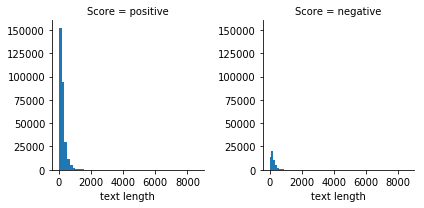

In [38]:
import seaborn as sns
g = sns.FacetGrid(data = b , col = 'Score')
g.map(plt.hist , 'text length' , bins = 50)
plt.show()

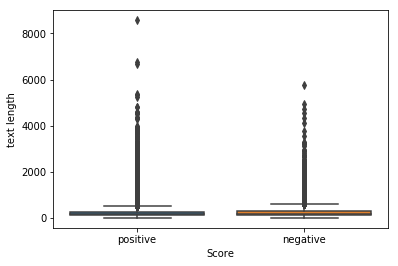

In [39]:
sns.boxplot(x='Score', y='text length', data=b)
plt.show()

It seems clearer from above plots that text length  won't be a helpful featurer for classification

### Function for standardizing data

In [27]:
from sklearn.preprocessing import StandardScaler

In [28]:
# function for standardzing the data
def std_data(matrix):
    scaler  = StandardScaler(with_mean=False)
    scaler.fit(matrix)
    return scaler.transform(matrix) 
 

In [28]:
# picking top 100k data points 
sampled_data = b.head(100000)

In [29]:
sampled_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,com_text,CleanedText,text length
76881,76882,B00002N8SM,A32DW342WBJ6BX,Buttersugar,0,0,positive,2000-01-24,A sure death for flies,I bought a few of these after my apartment was...,A sure death for flies I bought a few of these...,sure death fli bought apart infest fruit fli h...,172
374449,374450,B00004CI84,ACJR7EQF9S6FP,Jeremy Robertson,2,3,positive,2000-02-26,Bettlejuice...Bettlejuice...BETTLEJUICE!,What happens when you say his name three times...,Bettlejuice...Bettlejuice...BETTLEJUICE! What ...,bettlejuic bettlejuic bettlejuic happen say na...,633
1244,1245,B00002Z754,A29Z5PI9BW2PU3,Robbie,7,7,positive,2000-06-23,Great Product,This was a really good idea and the final prod...,Great Product This was a really good idea and ...,great product realli good idea final product o...,116
1243,1244,B00002Z754,A3B8RCEI0FXFI6,B G Chase,10,10,positive,2000-06-29,WOW Make your own 'slickers' !,I just received my shipment and could hardly w...,WOW Make your own 'slickers' ! I just received...,wow make slicker receiv shipment could hard wa...,250
131216,131217,B00004RAMX,A5NQLNC6QPGSI,Kim Nason,7,8,positive,2000-07-31,End your Gopher Problems,I have just recently purchased the Woodstream ...,End your Gopher Problems I have just recently ...,end gopher problem recent purchas woodstream c...,275


In [30]:
# checking how much points are positive and negative
sampled_data['Score'].value_counts()

positive    87792
negative    12208
Name: Score, dtype: int64

In [31]:
# splitting  data into train and test set
def response_label(sign):
    if sign == "positive":
        return 1                               # positive-----> 1
    else:
        return -1                              # negative-----> -1 
    
sampled_data["Score"] = sampled_data["Score"].map(response_label)
X_train, X_test, Y_train, Y_test  = train_test_split(sampled_data['CleanedText'],sampled_data['Score'], test_size=0.3, random_state=45)

In [32]:
sampled_data["Score"].value_counts()

 1    87792
-1    12208
Name: Score, dtype: int64

## Bag of Words

#### Vectorizing & Standarzing both train and test data

In [33]:
#CountVectorizer()--> Converts a collection of text documents to a matrix of token counts

# Initialize a CountVectorizer object: count_vectorizer
count_vect = CountVectorizer(ngram_range = (1,2) , dtype = 'float')

# Transforming train/test data into bag of words
bow_X_train_matrix = count_vect.fit_transform(X_train.values)
print("Train Dataset: ", bow_X_train_matrix.shape)

bow_X_test_matrix = count_vect.transform(X_test.values)
print("Test Dataset: " , bow_X_test_matrix.shape)

Train Dataset:  (70000, 923323)
Test Dataset:  (30000, 923323)


In [34]:
# standarzing both train and test matrix 
bow_std_X_train_matrix = std_data(bow_X_train_matrix)
bow_std_X_test_matrix = std_data(bow_X_test_matrix)

### Using SGD Classifier with hinge loss  


In [35]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn import linear_model

tuned_parameters = [{'alpha': [10**-4,10**-3, 10**-2,10**-1, 10**0,10, 10**2,10**3, 10**4]}]
linear_clf = linear_model.SGDClassifier(loss = 'hinge' )
tscv = TimeSeriesSplit(n_splits=10)                    
svm_linear_clf_using_grid = GridSearchCV(linear_clf, tuned_parameters, cv = tscv,scoring='f1' , n_jobs = -1 , verbose = 1)
svm_linear_clf_using_grid.fit(bow_std_X_train_matrix , Y_train)

Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   24.0s finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=10),
       error_score='raise-deprecating',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=[{'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=1)

In [36]:
# checking cross validation scores
cv_score = list(svm_linear_clf_using_grid.cv_results_.get('mean_test_score'))
alpha_values = [10**-4,10**-3, 10**-2,10**-1, 10**0,10, 10**2,10**3, 10**4]
for i in range(len(cv_score)):
    print('f1_score for alpha = ',alpha_values[i],'is ',cv_score[i] )

f1_score for alpha =  0.0001 is  0.9352507714751911
f1_score for alpha =  0.001 is  0.9359523288329041
f1_score for alpha =  0.01 is  0.9371477460817152
f1_score for alpha =  0.1 is  0.9423047736664752
f1_score for alpha =  1 is  0.9475100526992722
f1_score for alpha =  10 is  0.938706377799091
f1_score for alpha =  100 is  0.9342697388664427
f1_score for alpha =  1000 is  0.9341064501013039
f1_score for alpha =  10000 is  0.9318454270152968


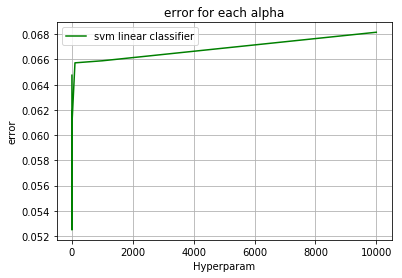

best parameter: {'alpha': 1}


In [37]:

acc_score= svm_linear_clf_using_grid.cv_results_.get('mean_test_score')
error = [1-x for x in acc_score]

hyperparam = np.array([10**-4,10**-3, 10**-2,10**-1, 10**0,10, 10**2,10**3, 10**4] )
plt.plot(hyperparam ,error ,'g' ,label="svm linear classifier"  )
plt.xlabel('Hyperparam')
plt.ylabel('error')
plt.title('error for each alpha')
plt.legend()
plt.grid()
plt.show()
print("best parameter:" ,svm_linear_clf_using_grid.best_params_ )

Test accuracy:  0.9201333333333334
Train accuracy:  0.9999142857142858
              precision    recall  f1-score   support

          -1       0.94      0.35      0.51      3546
           1       0.92      1.00      0.96     26454

   micro avg       0.92      0.92      0.92     30000
   macro avg       0.93      0.67      0.73     30000
weighted avg       0.92      0.92      0.90     30000



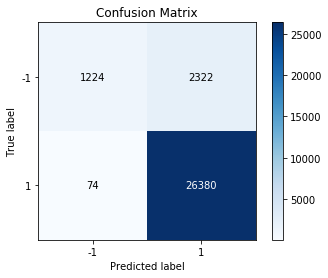

In [38]:

from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV

clf = SGDClassifier(alpha=svm_linear_clf_using_grid.best_params_['alpha'], loss='hinge', random_state=42)
clf.fit(bow_std_X_train_matrix , Y_train)
calib_clf = CalibratedClassifierCV(clf, method="sigmoid")
calib_clf.fit(bow_std_X_train_matrix , Y_train)

# test accuracy
print('Test accuracy: ',calib_clf.score(bow_std_X_test_matrix , Y_test))
# train accuracy
print('Train accuracy: ',calib_clf.score(bow_std_X_train_matrix , Y_train))

test_prediction = calib_clf.predict(bow_std_X_test_matrix)
print(classification_report(Y_test, test_prediction))

import scikitplot.metrics as sciplot
sciplot.plot_confusion_matrix(Y_test, test_prediction)
plt.show()



### Log Loss

In [39]:
# computing log loss
from sklearn.metrics import log_loss
y_prob_pred= calib_clf.predict_proba(bow_std_X_test_matrix)
log_loss(Y_test, y_prob_pred, labels=clf.classes_)

0.25369796251873705

### AUC Score

In [64]:
from sklearn.metrics import roc_auc_score
roc_auc_score(Y_test , y_prob_pred[:,1])

0.8596899742451124

### Important Features

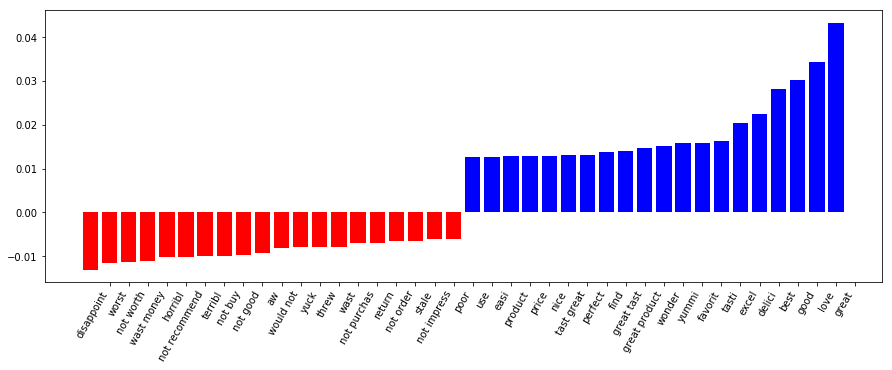

In [70]:
#Source: https://medium.com/@aneesha/visualising-top-features-in-linear-svm-with-scikit-learn-and-matplotlib-3454ab18a14d 

def plot_coefficients(classifier, feature_names, top_features=20):
 coef = classifier.coef_.ravel()
 top_positive_coefficients = np.argsort(coef)[-top_features:]
 top_negative_coefficients = np.argsort(coef)[:top_features]
 top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
 # create plot
 plt.figure(figsize=(15, 5))
 colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
 plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
 feature_names = np.array(feature_names)
 plt.xticks(np.arange(1, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60, ha='right')
 plt.show()


plot_coefficients(clf, count_vect.get_feature_names())

# TF-IDF

In [42]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
# Transforming train/test data into tf-idf
tf_idf_X_train_matrix = tf_idf_vect.fit_transform(X_train.values)
print(tf_idf_X_train_matrix.shape)
tf_idf_X_test_matrix = tf_idf_vect.transform(X_test.values)
print(tf_idf_X_test_matrix.shape)

(17500, 326652)
(7500, 326652)


In [72]:
tfidf_std_X_train_matrix = std_data(tf_idf_X_train_matrix)
tfidf_std_X_test_matrix = std_data(tf_idf_X_test_matrix)

In [73]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn import linear_model

tuned_parameters = [{'alpha': [10**-4,10**-3, 10**-2,10**-1, 10**0,10, 10**2,10**3, 10**4]}]
linear_clf = linear_model.SGDClassifier(loss = 'hinge' )
tscv = TimeSeriesSplit(n_splits=10)                    
svm_linear_clf_using_grid = GridSearchCV(linear_clf, tuned_parameters, cv = tscv,scoring='f1' , n_jobs = -1 , verbose = 1)
svm_linear_clf_using_grid.fit(tfidf_std_X_train_matrix , Y_train)

Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   21.1s finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=10),
       error_score='raise-deprecating',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=[{'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=1)

In [74]:
# checking cross validation scores
cv_score = list(svm_linear_clf_using_grid.cv_results_.get('mean_test_score'))
alpha_values = [10**-4,10**-3, 10**-2,10**-1, 10**0,10, 10**2,10**3, 10**4]
for i in range(len(cv_score)):
    print('f1_score for alpha = ',alpha_values[i],'is ',cv_score[i] )

f1_score for alpha =  0.0001 is  0.9385517787257349
f1_score for alpha =  0.001 is  0.9384457603382427
f1_score for alpha =  0.01 is  0.9393050343556121
f1_score for alpha =  0.1 is  0.9436245416927154
f1_score for alpha =  1 is  0.9444284399700633
f1_score for alpha =  10 is  0.9373780567029852
f1_score for alpha =  100 is  0.9341455956548304
f1_score for alpha =  1000 is  0.934059482177647
f1_score for alpha =  10000 is  0.9340214295115356


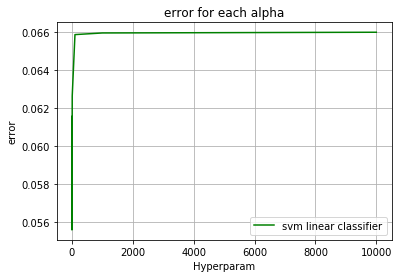

best parameter: {'alpha': 1}


In [75]:
acc_score= svm_linear_clf_using_grid.cv_results_.get('mean_test_score')
error = [1-x for x in acc_score]

hyperparam = np.array([10**-4,10**-3, 10**-2,10**-1, 10**0,10, 10**2,10**3, 10**4] )
plt.plot(hyperparam ,error ,'g' ,label="svm linear classifier"  )
plt.xlabel('Hyperparam')
plt.ylabel('error')
plt.title('error for each alpha')
plt.legend()
plt.grid()
plt.show()
print("best parameter:" ,svm_linear_clf_using_grid.best_params_ )

Test accuracy:  0.9284333333333333
Train accuracy:  0.9999714285714286
              precision    recall  f1-score   support

          -1       0.88      0.45      0.60      3546
           1       0.93      0.99      0.96     26454

   micro avg       0.93      0.93      0.93     30000
   macro avg       0.91      0.72      0.78     30000
weighted avg       0.93      0.93      0.92     30000



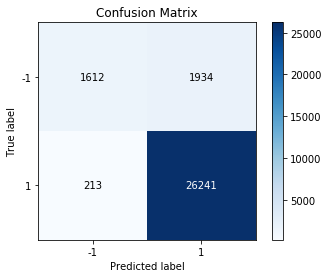

In [76]:
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV

clf = SGDClassifier(alpha=svm_linear_clf_using_grid.best_params_['alpha'], loss='hinge', random_state=42)
clf.fit(tfidf_std_X_train_matrix , Y_train)
calib_clf = CalibratedClassifierCV(clf, method="sigmoid")
calib_clf.fit(tfidf_std_X_train_matrix , Y_train)

# test accuracy
print('Test accuracy: ',calib_clf.score(tfidf_std_X_test_matrix , Y_test))
# train accuracy
print('Train accuracy: ',calib_clf.score(tfidf_std_X_train_matrix , Y_train))

test_prediction = calib_clf.predict(tfidf_std_X_test_matrix)
print(classification_report(Y_test, test_prediction))

import scikitplot.metrics as sciplot
sciplot.plot_confusion_matrix(Y_test, test_prediction)
plt.show()


### LOG Loss & AUC Score

In [77]:
# computing log loss
from sklearn.metrics import log_loss
y_prob_pred= calib_clf.predict_proba(tfidf_std_X_test_matrix)
log_loss(Y_test, y_prob_pred, labels=clf.classes_)

0.2165177062615434

In [78]:
roc_auc_score(Y_test , y_prob_pred[:,1])

0.8910599680506182

### Important Features

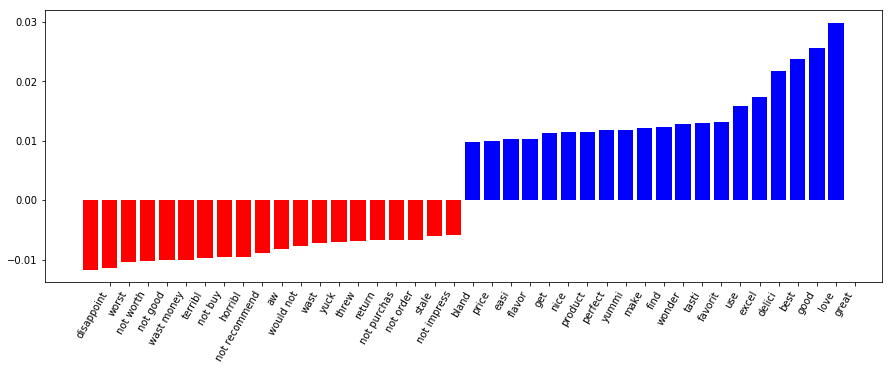

In [80]:
plot_coefficients(clf, tf_idf_vect.get_feature_names())

### Avg Word2Vec

In [82]:
list_of_sent=[]
for sent in X_train.values:
    list_of_sent.append(sent.split())
    
w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4) 

sent_vectors = [];
for sent in list_of_sent:
    sent_vec = np.zeros(50)
    cnt_words =0;
    for word in sent:
        if word in w2v_model:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)

w2vec_X_train_matrix = np.array(sent_vectors)

In [83]:
list_of_sent=[]
for sent in X_test.values:
    list_of_sent.append(sent.split())
    
sent_vectors = [];
for sent in list_of_sent:
    sent_vec = np.zeros(50)
    cnt_words =0;
    for word in sent:
        if word in w2v_model:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
    
w2vec_X_test_matrix = np.array(sent_vectors)


In [84]:
# standrizing data
w2vec_std_X_train_matrix = std_data(w2vec_X_train_matrix)
w2vec_std_X_test_matrix = std_data(w2vec_X_test_matrix)

In [85]:

tuned_parameters = [{'alpha': [10**-4,10**-3, 10**-2,10**-1, 10**0,10, 10**2,10**3, 10**4]}]
linear_clf = linear_model.SGDClassifier(loss = 'hinge' )
tscv = TimeSeriesSplit(n_splits=10)                    
svm_linear_clf_using_grid = GridSearchCV(linear_clf, tuned_parameters, cv = tscv,scoring='f1' , n_jobs = -1 , verbose = 1)
svm_linear_clf_using_grid.fit(w2vec_std_X_train_matrix, Y_train)

Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    7.1s finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=10),
       error_score='raise-deprecating',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=[{'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=1)

In [86]:
# checking cross validation scores
cv_score = list(svm_linear_clf_using_grid.cv_results_.get('mean_test_score'))
alpha_values = [10**-4,10**-3, 10**-2,10**-1, 10**0,10, 10**2,10**3, 10**4]
for i in range(len(cv_score)):
    print('f1_score for alpha = ',alpha_values[i],'is ',cv_score[i] )

f1_score for alpha =  0.0001 is  0.9303375224135744
f1_score for alpha =  0.001 is  0.9493927895817726
f1_score for alpha =  0.01 is  0.9526298204817318
f1_score for alpha =  0.1 is  0.940859703443529
f1_score for alpha =  1 is  0.9339431890353183
f1_score for alpha =  10 is  0.9339431890353183
f1_score for alpha =  100 is  0.9339431890353183
f1_score for alpha =  1000 is  0.9339431890353183
f1_score for alpha =  10000 is  0.8408035467479726


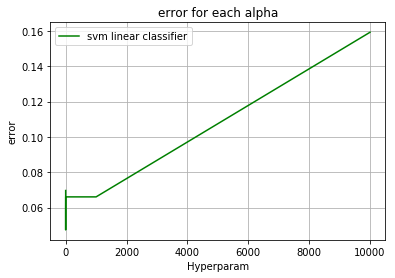

best parameter: {'alpha': 0.01}


In [87]:
acc_score= svm_linear_clf_using_grid.cv_results_.get('mean_test_score')
error = [1-x for x in acc_score]

hyperparam = np.array([10**-4,10**-3, 10**-2,10**-1, 10**0,10, 10**2,10**3, 10**4] )
plt.plot(hyperparam ,error ,'g' ,label="svm linear classifier"  )
plt.xlabel('Hyperparam')
plt.ylabel('error')
plt.title('error for each alpha')
plt.legend()
plt.grid()
plt.show()
print("best parameter:" ,svm_linear_clf_using_grid.best_params_ )

Test accuracy:  0.9181666666666667
Train accuracy:  0.9182857142857143
              precision    recall  f1-score   support

          -1       0.72      0.50      0.59      3546
           1       0.94      0.97      0.95     26454

   micro avg       0.92      0.92      0.92     30000
   macro avg       0.83      0.74      0.77     30000
weighted avg       0.91      0.92      0.91     30000



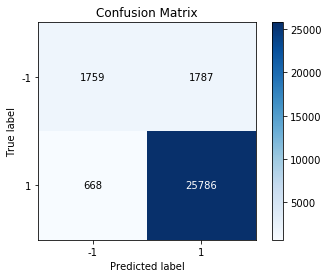

In [88]:
clf = SGDClassifier(alpha=svm_linear_clf_using_grid.best_params_['alpha'], loss='hinge', random_state=42)
clf.fit(w2vec_std_X_train_matrix , Y_train)
calib_clf = CalibratedClassifierCV(clf, method="sigmoid")
calib_clf.fit(w2vec_std_X_train_matrix , Y_train)

# test accuracy
print('Test accuracy: ',calib_clf.score(w2vec_std_X_test_matrix , Y_test))
# train accuracy
print('Train accuracy: ',calib_clf.score(w2vec_std_X_train_matrix , Y_train))

test_prediction = calib_clf.predict(w2vec_std_X_test_matrix)
print(classification_report(Y_test, test_prediction))

import scikitplot.metrics as sciplot
sciplot.plot_confusion_matrix(Y_test, test_prediction)
plt.show()


In [89]:
# computing log loss
from sklearn.metrics import log_loss
y_prob_pred= calib_clf.predict_proba(w2vec_std_X_test_matrix)
log_loss(Y_test, y_prob_pred, labels=clf.classes_)

0.201118173828724

In [90]:
# auc score
roc_auc_score(Y_test , y_prob_pred[:,1])

0.9273908020524598

## Tf-Idf W2Vec

In [91]:
list_of_sent=[]
for sent in X_train.values:
    list_of_sent.append(sent.split())

w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4)

model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(X_train.values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))
    
tfidf_feat = tf_idf_vect.get_feature_names()
tfidf_sent_vectors_X_train = []
row=0
for sent in list_of_sent: #list_of_sent
    sent_vec = np.zeros(50)
    weight_sum =0;
    for word in sent:
        if word in w2v_model:
            vec = w2v_model.wv[word]
         # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_X_train.append(sent_vec)
    row += 1

In [92]:
list_of_sent=[]
for sent in X_test.values:
    list_of_sent.append(sent.split())


tfidf_sent_vectors_X_test = [];
row=0;
for sent in list_of_sent: #list_of_sent
    sent_vec = np.zeros(50)
    weight_sum =0;
    for word in sent:
        if word in w2v_model:
            vec = w2v_model.wv[word]
               # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_X_test.append(sent_vec)
    row += 1


In [93]:
tfidf_w2vec_std_X_train_matrix = std_data(tfidf_sent_vectors_X_train)
tfidf_w2vec_std_X_test_matrix = std_data(tfidf_sent_vectors_X_test)

In [94]:
tuned_parameters = [{'alpha': [10**-4,10**-3, 10**-2,10**-1, 10**0,10, 10**2,10**3, 10**4]}]
linear_clf = linear_model.SGDClassifier(loss = 'hinge' )
tscv = TimeSeriesSplit(n_splits=10)                    
svm_linear_clf_using_grid = GridSearchCV(linear_clf, tuned_parameters, cv = tscv,scoring='f1' , n_jobs = -1 , verbose = 1)
svm_linear_clf_using_grid.fit(tfidf_w2vec_std_X_train_matrix, Y_train)

Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    7.3s finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=10),
       error_score='raise-deprecating',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=[{'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=1)

In [95]:
# checking cross validation scores
cv_score = list(svm_linear_clf_using_grid.cv_results_.get('mean_test_score'))
alpha_values = [10**-4,10**-3, 10**-2,10**-1, 10**0,10, 10**2,10**3, 10**4]
for i in range(len(cv_score)):
    print('f1_score for alpha = ',alpha_values[i],'is ',cv_score[i] )

f1_score for alpha =  0.0001 is  0.9371971194515392
f1_score for alpha =  0.001 is  0.9435871700821421
f1_score for alpha =  0.01 is  0.9447451764438975
f1_score for alpha =  0.1 is  0.9348357619054963
f1_score for alpha =  1 is  0.9339431890353183
f1_score for alpha =  10 is  0.9339431890353183
f1_score for alpha =  100 is  0.8404190926497761
f1_score for alpha =  1000 is  0.8405975638257978
f1_score for alpha =  10000 is  0.9339431890353183


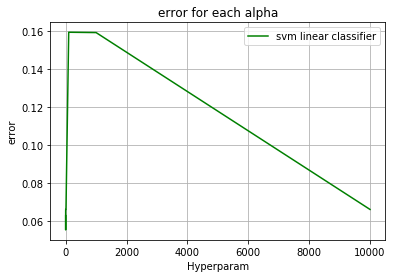

best parameter: {'alpha': 0.01}


In [96]:
acc_score= svm_linear_clf_using_grid.cv_results_.get('mean_test_score')
error = [1-x for x in acc_score]

hyperparam = np.array([10**-4,10**-3, 10**-2,10**-1, 10**0,10, 10**2,10**3, 10**4] )
plt.plot(hyperparam ,error ,'g' ,label="svm linear classifier"  )
plt.xlabel('Hyperparam')
plt.ylabel('error')
plt.title('error for each alpha')
plt.legend()
plt.grid()
plt.show()
print("best parameter:" ,svm_linear_clf_using_grid.best_params_ )

Test accuracy:  0.9049
Train accuracy:  0.9039714285714285
              precision    recall  f1-score   support

          -1       0.69      0.36      0.47      3546
           1       0.92      0.98      0.95     26454

   micro avg       0.90      0.90      0.90     30000
   macro avg       0.80      0.67      0.71     30000
weighted avg       0.89      0.90      0.89     30000



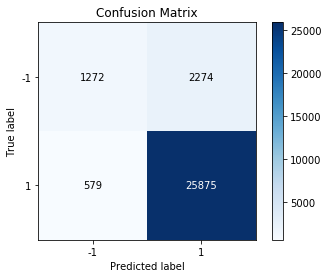

In [97]:
clf = SGDClassifier(alpha=svm_linear_clf_using_grid.best_params_['alpha'], loss='hinge', random_state=42)
clf.fit(tfidf_w2vec_std_X_train_matrix , Y_train)
calib_clf = CalibratedClassifierCV(clf, method="sigmoid")
calib_clf.fit(tfidf_w2vec_std_X_train_matrix , Y_train)

# test accuracy
print('Test accuracy: ',calib_clf.score(tfidf_w2vec_std_X_test_matrix , Y_test))
# train accuracy
print('Train accuracy: ',calib_clf.score(tfidf_w2vec_std_X_train_matrix , Y_train))

test_prediction = calib_clf.predict(tfidf_w2vec_std_X_test_matrix)
print(classification_report(Y_test, test_prediction))

import scikitplot.metrics as sciplot
sciplot.plot_confusion_matrix(Y_test, test_prediction)
plt.show()


In [98]:
# computing log loss
from sklearn.metrics import log_loss
y_prob_pred= calib_clf.predict_proba(tfidf_w2vec_std_X_test_matrix)
log_loss(Y_test, y_prob_pred, labels=clf.classes_)

0.2382735648467131

In [99]:
roc_auc_score(Y_test , y_prob_pred[:,1])

0.8922503731215838

 # SVM using RBF kernel

In [29]:
sampled_data = b.head(25000)

In [30]:
def response_label(sign):
    if sign == "positive":
        return 1                               # positive-----> 1
    else:
        return -1                              # negative-----> -1 
    
sampled_data["Score"] = sampled_data["Score"].map(response_label)
X_train, X_test, Y_train, Y_test  = train_test_split(sampled_data['CleanedText'],sampled_data['Score'], test_size=0.3, random_state=45)

## Bag of words

In [102]:
#CountVectorizer()--> Converts a collection of text documents to a matrix of token counts

# Initialize a CountVectorizer object: count_vectorizer
count_vect = CountVectorizer(ngram_range = (1,1) , dtype = 'float' , min_df = 50 , max_df = 0.6)

# Transforming train/test data into bag of words
bow_X_train_matrix = count_vect.fit_transform(X_train.values)
print("Train Dataset: ", bow_X_train_matrix.shape)

bow_X_test_matrix = count_vect.transform(X_test.values)
print("Test Dataset: " , bow_X_test_matrix.shape)

Train Dataset:  (17500, 1413)
Test Dataset:  (7500, 1413)


In [103]:
bow_std_X_train_matrix = std_data(bow_X_train_matrix)
bow_std_X_test_matrix = std_data(bow_X_test_matrix)

In [109]:
clf = SVC(max_iter = 2000)
param = {'C':[0.001,0.01,0.1,1,10,100,1000],
             'gamma':[0.001,0.01,0.1,1,10,100,1000]} 
tscv = TimeSeriesSplit(n_splits=5) #For time based splitting
svm_using_grid = GridSearchCV(clf,param,cv=tscv,verbose=1,n_jobs=-1 , scoring='f1')
svm_using_grid.fit(bow_std_X_train_matrix,Y_train)

Fitting 5 folds for each of 49 candidates, totalling 245 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 20.1min
[Parallel(n_jobs=-1)]: Done 245 out of 245 | elapsed: 25.7min finished
/opt/conda/lib/python3.6/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
       error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=2000, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'gamma': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=1)

In [110]:
print("Best HyperParameters: ",svm_using_grid.best_params_)
print("Best Accuracy: %.2f%%"%(svm_using_grid.best_score_*100))

Best HyperParameters:  {'C': 10, 'gamma': 0.001}
Best Accuracy: 95.65%


Test accuracy:  0.9269333333333334
Train accuracy:  0.9989714285714286
              precision    recall  f1-score   support

          -1       0.79      0.42      0.55       791
           1       0.94      0.99      0.96      6709

   micro avg       0.93      0.93      0.93      7500
   macro avg       0.86      0.70      0.75      7500
weighted avg       0.92      0.93      0.92      7500



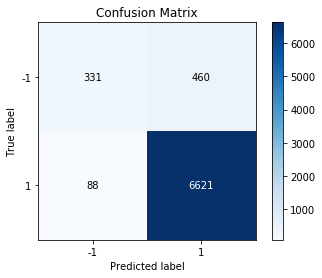

In [111]:
clf = SVC(C=svm_using_grid.best_params_['C'],gamma=svm_using_grid.best_params_['gamma'])
clf.fit(bow_std_X_train_matrix,Y_train)
# test accuracy
print('Test accuracy: ',clf.score(bow_std_X_test_matrix , Y_test))
# train accuracy
print('Train accuracy: ',clf.score(bow_std_X_train_matrix , Y_train))


test_prediction = clf.predict(bow_std_X_test_matrix)
print(classification_report(Y_test, test_prediction))

import scikitplot.metrics as sciplot
sciplot.plot_confusion_matrix(Y_test, test_prediction)
plt.show()

## Note:
The fit time complexity is more than quadratic with the number of samples which makes it hard to scale to dataset with more than a couple of 10000 samples, hence taking only 10k points for rest of assignment.

# Tf-idf

In [112]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,1) , min_df = 50 , max_df = 0.6)
# Transforming train/test data into tf-idf
tf_idf_X_train_matrix = tf_idf_vect.fit_transform(X_train.values)
print(tf_idf_X_train_matrix.shape)
tf_idf_X_test_matrix = tf_idf_vect.transform(X_test.values)
print(tf_idf_X_test_matrix.shape)

(17500, 1413)
(7500, 1413)


In [113]:
tfidf_std_X_train_matrix = std_data(tf_idf_X_train_matrix)
tfidf_std_X_test_matrix = std_data(tf_idf_X_test_matrix)

In [114]:
clf = SVC(max_iter = 2000)
param = {'C':[0.001,0.01,0.1,1,10,100,1000],
             'gamma':[0.001,0.01,0.1,1,10,100,1000]} 
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
svm_using_grid = GridSearchCV(clf,param,cv=tscv,verbose=1,n_jobs=-1, scoring ='f1')
svm_using_grid.fit(tfidf_std_X_train_matrix,Y_train)

Fitting 10 folds for each of 49 candidates, totalling 490 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 18.1min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 43.0min
[Parallel(n_jobs=-1)]: Done 490 out of 490 | elapsed: 48.1min finished
/opt/conda/lib/python3.6/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=10),
       error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=2000, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'gamma': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=1)

In [115]:
print("Best HyperParameters: ",svm_using_grid.best_params_)
print("Best Accuracy: %.2f%%"%(svm_using_grid.best_score_*100))

Best HyperParameters:  {'C': 10, 'gamma': 0.001}
Best Accuracy: 95.44%


Test accuracy:  0.9188
Train accuracy:  0.9886857142857143
              precision    recall  f1-score   support

          -1       0.89      0.26      0.41       791
           1       0.92      1.00      0.96      6709

   micro avg       0.92      0.92      0.92      7500
   macro avg       0.90      0.63      0.68      7500
weighted avg       0.92      0.92      0.90      7500



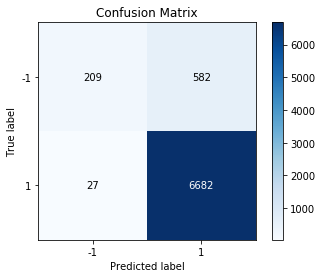

In [116]:
clf = SVC(C=1,gamma=0.001)
clf.fit(tfidf_std_X_train_matrix,Y_train)
# test accuracy
print('Test accuracy: ',clf.score(tfidf_std_X_test_matrix , Y_test))
# train accuracy
print('Train accuracy: ',clf.score(tfidf_std_X_train_matrix , Y_train))

test_prediction = clf.predict(tfidf_std_X_test_matrix)
print(classification_report(Y_test, test_prediction))

import scikitplot.metrics as sciplot
sciplot.plot_confusion_matrix(Y_test, test_prediction)
plt.show()

# Avg Word2Vec

In [31]:
list_of_sent=[]
for sent in X_train.values:
    list_of_sent.append(sent.split())
    
w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4) 

sent_vectors = [];
for sent in list_of_sent:
    sent_vec = np.zeros(50)
    cnt_words =0;
    for word in sent:
        if word in w2v_model:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)

w2vec_X_train_matrix = np.array(sent_vectors)

In [32]:
list_of_sent=[]
for sent in X_test.values:
    list_of_sent.append(sent.split())
    
sent_vectors = [];
for sent in list_of_sent:
    sent_vec = np.zeros(50)
    cnt_words =0;
    for word in sent:
        if word in w2v_model:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
    
w2vec_X_test_matrix = np.array(sent_vectors)


In [33]:
# standrizing data
w2vec_std_X_train_matrix = std_data(w2vec_X_train_matrix)
w2vec_std_X_test_matrix = std_data(w2vec_X_test_matrix)

In [34]:
# this code was run on 4GB machine hence used only 1000 iterations
clf = SVC(max_iter = 1000)
param = {'C':[0.001,0.01,0.1,1,10,100,1000],
             'gamma':[0.001,0.01,0.1,1,10,100,1000]} 
tscv = TimeSeriesSplit(n_splits=5) #For time based splitting
svm_using_grid = GridSearchCV(clf,param,cv=tscv,verbose=1,n_jobs=-1,scoring = 'f1')
svm_using_grid.fit(w2vec_std_X_train_matrix,Y_train)

Fitting 5 folds for each of 49 candidates, totalling 245 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  9.2min
[Parallel(n_jobs=-1)]: Done 245 out of 245 | elapsed: 11.6min finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
       error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=1000, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'gamma': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=1)

In [35]:
print("Best HyperParameters: ",svm_using_grid.best_params_)
print("Best Accuracy: %.3f%%"%(svm_using_grid.best_score_*100))

Best HyperParameters:  {'C': 1, 'gamma': 0.01}
Best Accuracy: 95.038%


Test accuracy:  0.9214666666666667
Train accuracy:  0.9208
             precision    recall  f1-score   support

         -1       0.80      0.34      0.48       791
          1       0.93      0.99      0.96      6709

avg / total       0.91      0.92      0.91      7500



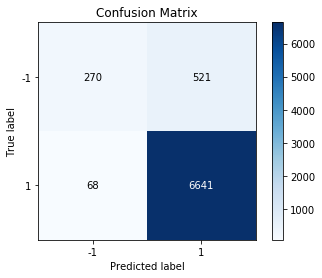

In [37]:
clf = SVC(C=svm_using_grid.best_params_['C'],gamma=svm_using_grid.best_params_['gamma'])
clf.fit(w2vec_std_X_train_matrix,Y_train)
# test accuracy
print('Test accuracy: ',clf.score(w2vec_std_X_test_matrix , Y_test))
# train accuracy
print('Train accuracy: ',clf.score(w2vec_std_X_train_matrix , Y_train))

test_prediction = clf.predict(w2vec_std_X_test_matrix)
print(classification_report(Y_test, test_prediction))

import scikitplot.metrics as sciplot
sciplot.plot_confusion_matrix(Y_test, test_prediction)
plt.show()

## Tf Idf W2Vec

In [43]:
list_of_sent=[]
for sent in X_train.values:
    list_of_sent.append(sent.split())

w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4)

model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(X_train.values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))
    
tfidf_feat = tf_idf_vect.get_feature_names()
tfidf_sent_vectors_X_train = []
row=0
for sent in list_of_sent: #list_of_sent
    sent_vec = np.zeros(50)
    weight_sum =0;
    for word in sent:
        if word in w2v_model:
            vec = w2v_model.wv[word]
         # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_X_train.append(sent_vec)
    row += 1

In [44]:
list_of_sent=[]
for sent in X_test.values:
    list_of_sent.append(sent.split())


tfidf_sent_vectors_X_test = [];
row=0;
for sent in list_of_sent: #list_of_sent
    sent_vec = np.zeros(50)
    weight_sum =0;
    for word in sent:
        if word in w2v_model:
            vec = w2v_model.wv[word]
               # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_X_test.append(sent_vec)
    row += 1


In [45]:
tfidf_w2vec_std_X_train_matrix = std_data(tfidf_sent_vectors_X_train)
tfidf_w2vec_std_X_test_matrix = std_data(tfidf_sent_vectors_X_test)

In [46]:
clf = SVC(max_iter = 1000)
param = {'C':[0.001,0.01,0.1,1,10,100,1000],
             'gamma':[0.001,0.01,0.1,1,10,100,1000]} 
tscv = TimeSeriesSplit(n_splits=5) #For time based splitting
svm_using_grid = GridSearchCV(clf,param,cv=tscv,verbose=1,n_jobs=-1)
svm_using_grid.fit(tfidf_w2vec_std_X_train_matrix,Y_train)

Fitting 5 folds for each of 49 candidates, totalling 245 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  9.8min
[Parallel(n_jobs=-1)]: Done 245 out of 245 | elapsed: 12.3min finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
       error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=1000, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'gamma': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [47]:
print("Best HyperParameters: ",svm_using_grid.best_params_)
print("Best Accuracy: %.3f%%"%(svm_using_grid.best_score_*100))

Best HyperParameters:  {'C': 1, 'gamma': 0.01}
Best Accuracy: 89.904%


Test accuracy:  0.9084
Train accuracy:  0.9060571428571429
             precision    recall  f1-score   support

         -1       0.79      0.18      0.29       791
          1       0.91      0.99      0.95      6709

avg / total       0.90      0.91      0.88      7500



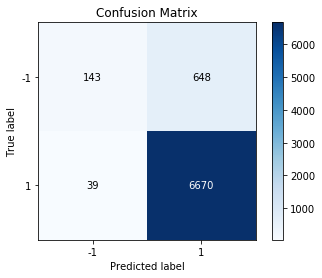

In [48]:
clf = SVC(C=svm_using_grid.best_params_['C'],gamma=svm_using_grid.best_params_['gamma'])
clf.fit(tfidf_w2vec_std_X_train_matrix,Y_train)
# test accuracy
print('Test accuracy: ',clf.score(tfidf_w2vec_std_X_test_matrix , Y_test))
# train accuracy
print('Train accuracy: ',clf.score(tfidf_w2vec_std_X_train_matrix , Y_train))

test_prediction = clf.predict(tfidf_w2vec_std_X_test_matrix)
print(classification_report(Y_test, test_prediction))

import scikitplot.metrics as sciplot
sciplot.plot_confusion_matrix(Y_test, test_prediction)
plt.show()

In [52]:
from prettytable import PrettyTable
x = PrettyTable()

### Linear SVM 

In [54]:
x.field_names = ["Vectorizer","Hyperparam", "Train accuracy" , "Test accuracy","f1-score" , 'auc score']
x.add_row(['BOW' , '1', '99.9','92.0','0.90' , '0.85' ])
x.add_row(['Tf-idf' , '1', '99.9','92.8','0.92' , '0.89'])
x.add_row(['w2vec' , '0.01', '91.82','91.81','0.91', '0.92' ])
x.add_row(['tfidf w2vec' , '0.01', '90.39','90.49','0.89' , '0.892'])
print(x)

+-------------+------------+----------------+---------------+----------+-----------+
|  Vectorizer | Hyperparam | Train accuracy | Test accuracy | f1-score | auc score |
+-------------+------------+----------------+---------------+----------+-----------+
|     BOW     |     1      |      99.9      |      92.0     |   0.90   |    0.85   |
|    Tf-idf   |     1      |      99.9      |      92.8     |   0.92   |    0.89   |
|    w2vec    |    0.01    |     91.82      |     91.81     |   0.91   |    0.92   |
| tfidf w2vec |    0.01    |     90.39      |     90.49     |   0.89   |   0.892   |
|     BOW     |     1      |      99.9      |      92.0     |   0.90   |    0.85   |
|    Tf-idf   |     1      |      99.9      |      92.8     |   0.92   |    0.89   |
|    w2vec    |    0.01    |     91.82      |     91.81     |   0.91   |    0.92   |
| tfidf w2vec |    0.01    |     90.39      |     90.49     |   0.89   |   0.892   |
+-------------+------------+----------------+---------------+----

### SVM using rbf kernel

In [62]:
x1 = PrettyTable()

In [63]:
x1.field_names = ["Vectorizer","C", "gamma" ,"Train accuracy" , "Test accuracy","f1-score" ]
x1.add_row(['BOW' , '10','0.01', '99.8','92.6','0.92' ])
x1.add_row(['Tf-idf' , '10','0.01', '98.8','91.8','0.90'])
x1.add_row(['w2vec' , '1','0.01', '92.04','92.14','0.91' ])
x1.add_row(['tfidf w2vec' , '1','0.01', '90.6','90.84','0.88' ])
print(x1)

+-------------+----+-------+----------------+---------------+----------+
|  Vectorizer | C  | gamma | Train accuracy | Test accuracy | f1-score |
+-------------+----+-------+----------------+---------------+----------+
|     BOW     | 10 |  0.01 |      99.8      |      92.6     |   0.92   |
|    Tf-idf   | 10 |  0.01 |      98.8      |      91.8     |   0.90   |
|    w2vec    | 1  |  0.01 |     92.04      |     92.14     |   0.91   |
| tfidf w2vec | 1  |  0.01 |      90.6      |     90.84     |   0.88   |
+-------------+----+-------+----------------+---------------+----------+


### Conclusion

1. Performance of SVM on unseen text data is quite good.
2. SVM can classify the data that are linearly seprable but if points are not linealy separable then we can use kernel trick to make it work.
3. Using kernel trick like rbf for high dimensional data is not a good option hence it is better to classify text data using linear svm.